<a href="https://colab.research.google.com/github/Sciok2000/ADM_HW5_Group16/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
from statistics import mean
from networkx.algorithms import community

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data

To get started, you have to download the data, as always, from here. Make sure you downloaded all files because we will work with them all.

In particular, the files contain the following:

- nodes.csv - Contains two columns (node, type), indicating the nodes' name and type (comic, hero).
- edges.csv - Contains two columns (hero, comic), indicating which comics the heroes appear in.
- hero-network.csv - Contains the network of heroes who have appeared together in the comics.

In [ ]:
edges = pd.read_csv('/content/drive/MyDrive/ADM_HW5/edges.csv')
hero = pd.read_csv('/content/drive/MyDrive/ADM_HW5/hero-network.csv')
nodes = pd.read_csv('/content/drive/MyDrive/ADM_HW5/nodes.csv')

In [ ]:
hero.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


## Data Preprocessing

In [ ]:
def pre_proc(df):
    df.drop(hero.loc[df['hero1'] == df['hero2']].index, inplace = True) # drop row that have the same hero in both columns.
    df.replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER', inplace = True) # replace "PAR" with "PARKER"
    df = df.applymap(lambda x: x.strip()) # remove extra spaces
    df = df.applymap(lambda x: x.rstrip("/")) # remove extra "/" at the end of the strings
    return df 

In [ ]:
pre_proc(hero)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


## Graphs setup

- **First graph:** Will be constructed using the data stored in the **'hero-network.csv'** file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered **weighted** and **undirected**. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be **lower** for heroes with **more collaborations**. Please specify which metric you used to select the weights in the report.

In [ ]:
# calculate number of collaborations between each pair of heroes
hero['weight'] = 1
hero_w = hero.groupby(["hero1", "hero2"], as_index=False).count()
hero_w.head()

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1


In [ ]:
hero_w.loc[hero_w["hero1"] == 'ZEUS'].tail(1)

,hero1,hero2,weight
223633,ZEUS,ZURAS,3


In [ ]:
hero_w.loc[hero_w["hero1"] == 'ZURAS'].loc[hero_w["hero2"] == "ZEUS"]

,hero1,hero2,weight
224098,ZURAS,ZEUS,1


In [ ]:
# we have to merge the pairs of heroes to avoid cycles in the graph
hero_w[['hero1','hero2']] = pd.DataFrame(np.sort(hero_w[['hero1', 'hero2']].values, axis=1))
hero_w = hero_w.groupby(['hero1', 'hero2']).weight.sum().reset_index()
hero_w.head()

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,G'RATH,1
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1


In [ ]:
# Compute the edges's weight using the inverse function
hero_w['weight'] = hero_w.weight.apply(lambda x: 1/x)
hero_w.head()

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1.0
1,24-HOUR MAN/EMMANUEL,G'RATH,1.0
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1.0
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1.0
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1.0


In [ ]:
G_hero=nx.from_pandas_edgelist(hero_w, 'hero1', 'hero2',edge_attr = 'weight', create_using=nx.MultiGraph)

In [ ]:
nx.info(G_hero)

/var/folders/zz/kmfgmg0s6dlfjck_41bc4rz80000gn/T/ipykernel_20433/699056702.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero)


'MultiGraph with 6426 nodes and 167207 edges'

- **Second graph:** The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in **'nodes.csv'**, and an edge between a hero node and a comic node can be found in **'edges.csv'** when the hero has appeared in that specific comic. This graph is assumed to be **undirected** and **unweighted**.

In [ ]:
nodes.head()

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


In [ ]:
edges.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [ ]:
G_comic=nx.from_pandas_edgelist(edges, 'hero', 'comic', create_using=nx.MultiGraph)

In [ ]:
nx.info(G_comic)

/var/folders/zz/kmfgmg0s6dlfjck_41bc4rz80000gn/T/ipykernel_20433/2865597581.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_comic)


'MultiGraph with 19090 nodes and 96104 edges'

In [ ]:
# we generate a list with all nodes of type "hero"
hero_type = nodes.node.loc[nodes['type'] == 'hero']
hero_type = hero_type.tolist()

In [ ]:
# for each node belonging to the list we set the "type" attribute to "hero" otherwise we set the "type" attribute to "comic"
for node in G_comic:
    if node in hero_type:
        G_comic.nodes[f'{node}']['type'] = 'hero'
    else:
        G_comic.nodes[f'{node}']['type'] = 'comic'      

In [ ]:
G_comic.nodes["24-HOUR MAN/EMMANUEL"]

{'type': 'hero'}

In [ ]:
G_comic.nodes["AA2 35"]

{'type': 'comic'}

# **2. Backend Implementation**
**Top N heroes** : The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.

In [ ]:
#After the user has inserted the wanted number of heroes to be considered in the analysis, these heroes are printed below in order of who appeard
#in the most number of comics 
def top_heroes(n): 
    if n > 0 and n <= len(edges['hero'].value_counts()): 
        top_N = edges['hero'].value_counts().head(n).index.tolist()
        return(top_N)
    elif n > len(edges['hero'].value_counts()):
        top_N = edges['hero'].value_counts().index.tolist()
        return(top_N)
    else:
        raise TypeError('Insert an INTEGER number')

## **Functionality 1** - extract the graph's features

For this point we are asked to define a functionality that returns some features of a given graph. We have to deal with two types of graphs: one for heroes and a bipartite one made of heroes and comics. The output will be different for the two types of graphs.

In [ ]:
#Define type_1 the graph obtained by hero data and type_2 the one obtained by edges and nodes data
type_1 = G_hero 
type_2 = G_comic

In [ ]:
#Function to visualize the degree distribution of the subgraph of G_hero
def plot_degree_dist_hero(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.xlabel('Degree value')
    plt.ylabel('Number of nodes')
    plt.show()

In [ ]:
#Function to visualize the degree distribution of the subgraph of G_comic
def plot_degree_dist_comic(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    plt.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.')
    plt.title('Degree Distribution')
    plt.xlabel('Degree value')
    plt.ylabel('Number of nodes')
    plt.show()

In [ ]:
#Function to extract Hubs from the degree distribution
def Hubs(G):
  d = [d for (n, d) in nx.degree(G)] #degree distribution
  q = np.quantile(d, 0.95) #quantile at level 0.95
  N = []
  for (n, d) in nx.degree(G):
    if d >= q:
      N.append(n)
  return(N)

In [ ]:
#Function to find out if the graph is sparse or dense. Parsity is when the number of edges of a graph 
#is close to the minimal number of edges, Density is when the number of edges of a graph is close to 
#the maximal number of edges 
def is_sparse_or_dense(G):
  d = [d for (n, d) in nx.degree(G)] #degree distribution
  q = max(d) 
  a = G.number_of_edges()
  if math.isclose(a, q) == True:
    return('Dense')
  else:
    return('Sparse')

In [ ]:
def functionality1(graph_data, graph_type, top_N): #graph_data is edges because it has all heroes and comics names, graph_type jas to chosen 
#between type_1(hero) or type_2(comic) and top_N denotes the heroes we're considering 

  #subgraph of the top heroes
  if graph_type == type_1:
    Subgraph = nx.subgraph(G_hero, top_N)
    number_of_nodes = Subgraph.number_of_nodes()
    #return(number_of_nodes)
    hero1 = []
    hero2 = []
    for i in top_N:
      for j in top_N:
        if i != j and i < j: #to delete collaborations already considered
          n_collab = Subgraph.number_of_edges(i, j)
          if n_collab > 0:
            hero1.append(i)
            hero2.append(j)
            C = n_collab
    c ={'hero1': hero1, 'hero2': hero2, 'Number of collaborations': C}
    Collab = pd.DataFrame(c)
    #Network density 
    Density = nx.density(Subgraph) 
    #average_degree_of_the_network 
    Average_degree = sum([d for (n, d) in nx.degree(Subgraph)]) / float(Subgraph.number_of_nodes())

    #network_Hubs
    #Hubs(Subgraph)

    #Sparse or Dense
    sd = is_sparse_or_dense(Subgraph)

    data = [['Number of nodes in the network', number_of_nodes],
    ['Density of the network', Density],
    ['Average degree of the network', Average_degree],
    ['Whether the network is sparse or dense', is_sparse_or_dense(Subgraph)]]
    print(tabulate(data, tablefmt="grid"))

    data1 = pd.DataFrame(Hubs(Subgraph), columns = ['Hubs'])
    head = ['Hubs']
    print(tabulate(data1,headers=head, tablefmt="grid"))

    bars = ('Beast','CapAm','DareD', 'Hulk', 'HTorch', 'Mr.Fant', 'SpiderM', 'Thing')
    x = Collab['hero1'].value_counts().index.tolist()
    y = list(Collab['hero1'].value_counts())
    plt.bar(bars, y)
    plt.title('Plot of the number of collaborations in descending order')
    plt.xlabel('Heroes')
    plt.ylabel('Numb of collab')
    plt.show()

    #network_degree_distribution
    plot_degree_dist_hero(Subgraph)

  else:
    for i in top_N:
      top_C = [n for n in G_comic.neighbors(i)]
    top_C_N = top_C + top_N #list of heroes and comics
    Subgraph = G_comic.subgraph(top_C_N)

    #number_of_nodes
    type_hero = 0
    type_comic = 0
    for node in Subgraph:
      if node in hero_type:
        type_hero += 1
      else:
        type_comic += 1
    number_of_nodes_hero =  type_hero 
    number_of_nodes_comic = type_comic 
    #print('Number of nodes (hero): ', type_hero)
    #print('Number of nodes (comic): ', type_comic)

    #number of heroes per comic 
    new_data = graph_data.loc[graph_data['hero'].isin(top_C_N)]
    Number_of_heroes_for_each_comic = new_data['comic'].value_counts()

    #Network density 
    Density = nx.density(Subgraph) 

    #network_degree_distribution
    #Degree_distr = plot_degree_dist_comic(Subgraph)

    #average_degree_of_the_network 
    d = [d for (n, d) in nx.degree(Subgraph)]
    Average_degree = sum(d)/len(d)

    #network_Hubs
    #Hubs(Subgraph)

    #Sparse or Dense
    #is_sparse_or_dense(Subgraph)

    data = [['Number of nodes in the network (hero)', number_of_nodes_hero],
    ['Number of nodes in the network (comic)', number_of_nodes_comic],
    ['Density of the network', Density],
    ['Average degree of the network', Average_degree],
    ['Whether the network is sparse or dense', is_sparse_or_dense(Subgraph)]]
    print(tabulate(data, tablefmt="grid"))

    data1 = pd.DataFrame(Hubs(Subgraph), columns = ['Hubs'])
    head = ['Hubs']
    print(tabulate(data1,headers=head, tablefmt="grid"))

    x = new_data['comic'].value_counts().head(15).index.tolist()
    y = new_data['comic'].value_counts().head(15)
    plt.bar(y,x)
    plt.title('Plot of the number of heroes in each comic (first 15 comics)')
    plt.xlabel('Number of heroes')
    plt.ylabel('Comics')
    plt.show()

    #network_degree_distribution
    print('Plot of the degree distribution: ')
    plot_degree_dist_comic(Subgraph)

## **Functionality 2** - Find top superheroes!

Here the goal is, given one of the four different metrics (Betweenness centrality, Pagerank, Closeness centrality and Degree Centrality) as an input to a function, obtaining the respevtive values for the whole graph's nodes and for a specific node. With the results are also printed some usful informations about the metric we are taking into account.

In [ ]:
def functionality2(graph_data, node, metric, top_N):
  for i in top_N:
    top_C = [n for n in G_comic.neighbors(i)]
    top_C_N = top_C + top_N #nodes of both types hero/comic
    Subgraph = G_comic.subgraph(top_C_N)
  #if the chosen metric is Betweenness centrality:
  if metric == 'Betweenness centrality':
    dictionary1 = nx.betweenness_centrality(Subgraph)
    values1 = dictionary1.values()
    value1 = nx.betweenness_centrality(Subgraph, normalized=True)[node]
    data = [['Average betweenness centrality of the Subgraph', mean(values1)],
            ['Betweenness centrality of the given node', value1]]
    print(tabulate(data, tablefmt="grid"))
    print('A vertice with high betweenness centrality value means that it is infuent for the network because of its control over the infos\npassing between others.')

  #if the chosen metric is Pagerank
  elif metric == 'Pagerank':
    dictionary2 = nx.pagerank_numpy(Subgraph)
    values2 = dictionary2.values()
    value2 = nx.pagerank_numpy(Subgraph)[node]
    data = [['Average pagerank of the Subgraph', mean(values2)],
            ['Pagerank centrality of the given node', value2]]
    print(tabulate(data, tablefmt="grid"))
    print('The PageRank algorithm measures the importance of each node within the graph, based on the number incoming relationships and\nthe importance of the corresponding source nodes. The higher the rank, the higher the importace of the node. ')

  #if the chosen metric is Closeness centrality
  elif metric == 'Closeness centrality':
    dictionary3 = nx.closeness_centrality(Subgraph)
    values3 = dictionary3.values()
    value3 = nx.closeness_centrality(Subgraph)[node]
    data = [['Average closeness centrality of the Subgraph', mean(values3)],
            ['Closeness centrality of the given node', value3]]
    print(tabulate(data, tablefmt="grid"))
    print('Closeness centrality of a node is a measure of centrality in a network, the more central a node is, the closer it is to all other nodes.\nA high value of the closeness centrality means that the vertice has close relationships with many vertices.')

  #if the chosen metric is Degree centrality 
  else:
    dictionary4 = nx.degree_centrality(Subgraph)
    values4 = dictionary4.values()
    value4 = nx.degree_centrality(Subgraph)[node]
    data = [['Average degree centrality of the Subgraph', mean(values4)],
            ['Closeness degree of the given node', value4]]
    print(tabulate(data, tablefmt="grid"))
    print('Degree centrality is defined as the number of links incident upon a node. Higher values mean that the node is more central.\nIt assigns an importance score based simply on the number of links held by each node.')

## **Functionality 3** - Shortest ordered Route

Now we have to implement an algorithm that, given a starting hero **h_1**, a final hero **h_n** and a list of heroes **h**, returns us an **ordered** list of comics to read to go from hero_1 to hero_n passing through all the heroes in the list h in order and the **graph of the shortest ordered path**.

In [ ]:
def functionality3(graph_data, h, h_1, h_n, top_N):
  #create the Subgraph
  for i in top_N:
    top_C = [n for n in G_comic.neighbors(i)]
    top_C_N = top_C + top_N #list of heroes and comics
    Subgraph = G_comic.subgraph(top_C_N)
  if nx.is_connected(Subgraph) == False:
    #if the Subgraph is not connected the function will say that is not such path
    print('There is no such path')

  else:
    #if the Subgraph is connected, the shortest path between the ordered heroes in h list will be computed 

    graph = nx.empty_graph() #create an empty graph 
    nodes_1 = [] #list that will contain the shortest path between the heroes in order
    for i in range(0, len(h)-1):
      a = nx.shortest_path(Subgraph, h[i], h[i+1])
      nodes_1.append(a)


    node_1 = [] #list that will contain the type hero nodes for the graph 
    comic = [] #list that will contain the type comic nodes for the graph 
    for (a,b,c) in nodes_1:
      node_1.append(a)
      comic.append(b)
    print('Ordered comics: ')
    print(comic) #prints the ordered list of comics as they are reached in the shortest path

    graph.add_nodes_from(node_1) #add the hero nodes to the new graph
    graph.add_node(h_n) #add the last hero of the path as h_n given in input
    graph.add_nodes_from(comic) #add comic nodes to the new graph

    edges_list = [] #list that will contain all the nodes to connect
    for (i,j) in list(zip(node_1, comic)):
      edges_list.append(i)
      edges_list.append(j)
    edges_list.append(h_n)
    

    for i in range(0, len(edges_list)-1):
      graph.add_edge(edges_list[i], edges_list[i+1]) #add the edges to the new graph
    

    #change the nodes' labels
    mapping1 = {'THOR/DR. DONALD BLAK': '1(Thor)', 'FF 243' : '2(FF 243)', 'SPIDER-MAN/PETER PARKER': '3(Spider-Man)', 'A 221': '4(A 221)',
           'CAPTAIN AMERICA': '5(CapAmerica)', 'A 1': '6(A1)', 'IRON MAN/TONY STARK': '7(Iron Man)', 'A 1': '8',
           'THING/BENJAMIN J. GR': '9(Thing)', 'A 1': '10', 'HUMAN TORCH/JOHNNY S': '11(HumTorch)', 'A 1': '12', 'MR. FANTASTIC/REED R':'13(Mr.F)',
           'A 1': '6 8 10\n 12 14(A1)', 'HULK/DR. ROBERT BRUC': '15(Hulk)', 'A3 10': '16(A3 10)','WOLVERINE/LOGAN':'17(Wolverine)', 'A3 10': '16 18\n(A3 10)', 
           'INVISIBLE WOMAN/SUE': '19(InvWoman))'}
    graph1 = nx.relabel_nodes(graph, mapping1)
    print('Graph of the shortest ordered path')
    nx.draw(graph1, with_labels=True) #show the new graph 

## **Functionality 4** - Disconnecting Graphs



In [ ]:
def min_cut(G, heroA, heroB, N=0):
    """
    Output: The minimum number of links required to disconnect the original graph in two disconnected subgraphs.
    
    Args:
    
    G: The graph.
    heroA: The first hero.
    heroB: The second hero.
    """
    if N == 0:
        cutset = nx.minimum_edge_cut(G, heroA, heroB)
        print('The minimum number of links required to disconnect', heroA,"and",heroB, "is:", len(cutset))
    else:
        SG = G.subgraph(top_heroes(N))
        if heroA in top_heroes(N) and heroB in top_heroes(N):
            cutset = nx.minimum_edge_cut(SG, heroA, heroB)
            print('The minimum number of links required to disconnect', heroA,"and",heroB, "is:", len(cutset))
        else:
            raise TypeError(f"The heroes you are considering are not present in the top {N}")
        

In [ ]:
min_cut(G_hero, "SPIDER-MAN/PETER PARKER", "CAPTAIN AMERICA")

The minimum number of links required to disconnect SPIDER-MAN/PETER PARKER and CAPTAIN AMERICA is: 1734


## **Functionality 5** - Extracting Communities

In [ ]:
def edge_to_remove(G):
    """
    Find the EBC values for all the edges and then take off the edge with the largest value.
    
    Args:
    G: The graph.
    """
    G_dict = nx.edge_betweenness_centrality(G)
    edge = ()
    
    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break
    
    return edge

def girvan_newman(G, hero1 = None, hero2 = None):
    """
    Output: 
    - The minimum number of edges that should be removed to form communities.
    - A list of communities, each containing a list of heroes that belong to them.
    - If the Hero_1 and Hero_2 belongs to the same community.
    
    Args:
    
    G: The graph.
    hero1: The first hero.
    hero2: The second hero.
    """
    # find number of connected components
    sg = nx.connected_components(G)
    sg_count = nx.number_connected_components(G)
    
    while(sg_count == 1):
        G.remove_edge(edge_to_remove(G)[0], edge_to_remove(G)[1])
        min_edges =min_edges + 1
        sg = nx.connected_components(G)
        sg_count = nx.number_connected_components(G)
    
    node_groups = []
    
    for i in sg:
        node_groups.append(list(i))
        
    hero1_group = list()
    hero2_group = list()
    same_group = False
    
    # check if hero1 and hero2 are in the same group
    for group in node_groups:
        if hero1 in group:
            hero1_group = group
        if hero2 in group:
            hero2_group = group
    
    if hero1_group == hero2_group:
        same_group = True
    
    return same_group, node_groups

In [ ]:
# find communities in the graph
girvan_newman(G_hero.copy(), 'QUAGMIRE','COLLINS, TRACY' )

(True,
 [['MERIDIAN, DR. ROBERT',
   'AZRAEL',
   'GRASP',
   'REISZ, RAY',
   'JONES, NELL',
   'GORGON [INHUMAN]',
   'IRON FIST/DANIEL RAN',
   'BLACK PANTHER | MUTA',
   'SARDAN',
   'CLEMSON, MIKE',
   'MAXOV',
   'RICHARDS, FRANKLIN 2',
   'CHALMERS, CYNTHIA',
   'PYRAKH, COMMANDER',
   'PRINCE BAYAN',
   'BLUNT',
   'CHANEY, AMANDA',
   'PHARAOH KHAFRE',
   'REDSTONE/',
   'EKAK',
   'GARTH',
   'ASTRA',
   'ROCKETLAUNCHER/',
   'NAKOTA',
   'VANDERGILL, GEORGE',
   'LODESTONE/ANDREA',
   'DINAH-SOAR',
   'SPLICE/CHANDRA KU',
   'DRAKE, MALCOLM',
   'BLACK KNIGHT IV DOPP',
   'MASTER FOUR',
   'CATHODE/',
   'WOLFMAN, MARV',
   'RAMBO',
   'SISTER DREAM',
   'ABSALOM',
   'CHEN',
   'SHUMA-GORATH',
   'SMEDLEY',
   'FIELDS, PROF. WILLIA',
   'NOMAD III/JACK MONRO',
   'DE LA SPIROSA, COUNT',
   'TABUR',
   'BANSHEE/SEAN CASSIDY',
   'CORD, JANICE',
   'NOBILUS',
   'FIREFLY',
   'BETELHEIM, NORMA',
   'BRADDOCK, JAMES',
   'SUZIE',
   'HURRICANE II',
   'MOTHER INFERIOR',
   'SH

# **3. Frontend Implementation**
In this section, we ask you to build the visualizations for users' query results. We also expect you to showcase plots that can give us the most insight possible and comment accordingly.

## **Visualization 1** - Visualize some features of the network

Here we have to run the ***functionality1*** we created in the backend part and visualize the results in the requested format (tables and plots). <br> To show our work there are two examples below: one with a type_1 graph, the other with the type_2 graph.

In [ ]:
top_N = top_heroes(15)

+----------------------------------------+--------+
| Number of nodes in the network         | 9      |
+----------------------------------------+--------+
| Density of the network                 | 1.0    |
+----------------------------------------+--------+
| Average degree of the network          | 8.0    |
+----------------------------------------+--------+
| Whether the network is sparse or dense | Sparse |
+----------------------------------------+--------+
+----+-------------------------+
|    | Hubs                    |
+====+=========================+
|  0 | SPIDER-MAN/PETER PARKER |
+----+-------------------------+
|  1 | HULK/DR. ROBERT BRUC    |
+----+-------------------------+
|  2 | MR. FANTASTIC/REED R    |
+----+-------------------------+
|  3 | BEAST/HENRY &HANK& P    |
+----+-------------------------+
|  4 | DAREDEVIL/MATT MURDO    |
+----+-------------------------+
|  5 | THOR/DR. DONALD BLAK    |
+----+-------------------------+
|  6 | CAPTAIN AMERICA         |
+---

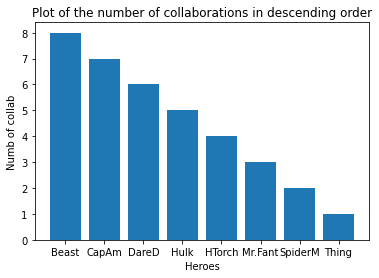

Plot of the degree distribution: 


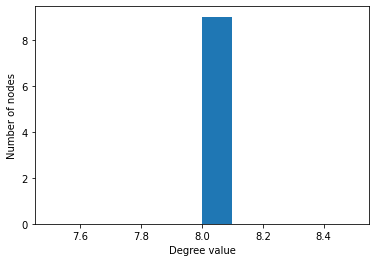

In [ ]:
functionality1(edges, type_1, top_N)

Some important features of the first graph (the one coming from the hero data) are shown here. In the first table we can find the **number of nodes in the network**, the **density of the network**, the **average degree of the network** and **whether the network is sparse or dense**. About this last thing, Multigraphs are more likely to be sparse so the result we obtained matches the expectations.<br> In the second table we have the **Hubs** which are the nodes having degrees more extensive than the 95th percentile of the degree distribution. In this specific case all heroes are connectd with each other (because they all collaborated at least once with all the others) so they all are hubs. <br> Than we plotted the number of collaborations heroes have between them without repeating the ones already considered. We already said that, in this case, all heroes collaborated with each other and this justifies the shape of the plot. <br> The last plot shows the degree distribution of the network. Since it is 8 for all heroes (in this case only), we just have a bar on the value 8 with height 9 (absolute frequency).

+----------------------------------------+-----------------------+
| Number of nodes in the network (hero)  | 14                    |
+----------------------------------------+-----------------------+
| Number of nodes in the network (comic) | 620                   |
+----------------------------------------+-----------------------+
| Density of the network                 | 0.0065981929722267905 |
+----------------------------------------+-----------------------+
| Average degree of the network          | 4.176656151419558     |
+----------------------------------------+-----------------------+
| Whether the network is sparse or dense | Sparse                |
+----------------------------------------+-----------------------+
+----+-------------------------+
|    | Hubs                    |
+====+=========================+
|  0 | THOR/DR. DONALD BLAK    |
+----+-------------------------+
|  1 | H2 279                  |
+----+-------------------------+
|  2 | A3 10                   |

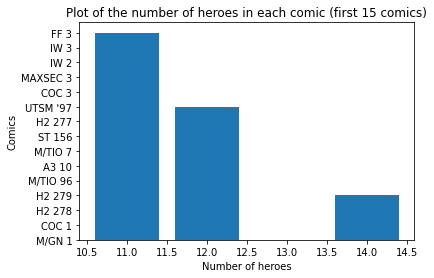

Plot of the degree distribution: 


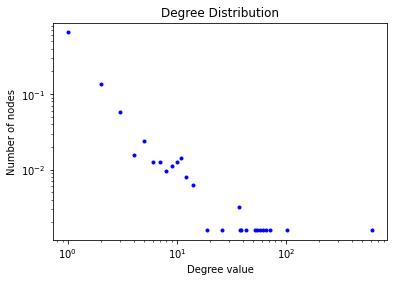

In [ ]:
functionality1(edges, type_2, top_N)

For the second graph (coming from edges and nodes data) we analysed almost the same features we considered for the first graph except for the division of the number of nodes in the two types (hero/comic) shown in the first table and the plot of the number of heroes for each comic which is done for the first 15 comics only for a better visualization. As the Output above, we also have the table with Hubs and the plot of the degree distribution which is different this time because we have a bigger number of nodes (given to the type comic nodes) and different values of the degree.

## **Visualization 2** - Visualize centrality measure

As before, we have to run the ***functionality2*** and show the results in the requested format (table). Below there are four examples, one for each centrality measure: **betweenness centrality**, **pagerank**, **closeness centrality** and **degree centrality**. In addition, at the end of every output there is a little explaination of what every measure is and what does it mean when the respective value is high.

In [ ]:
functionality2(edges, 'SPIDER-MAN/PETER PARKER', 'Betweenness centrality', top_N )

+------------------------------------------------+------------+
| Average betweenness centrality of the Subgraph | 0.00163463 |
+------------------------------------------------+------------+
| Betweenness centrality of the given node       | 0.0126933  |
+------------------------------------------------+------------+
A vertice with high betweenness centrality value means that it is infuent for the network because of its control over the infos
passing between others.


The betweenness cetrality measure is normalised so the range is between $[0, 1]$.

In [ ]:
functionality2(edges, 'CAPTAIN AMERICA', 'Pagerank centrality', top_N )

+------------------------------------------------+------------+
| Average betweenness centrality of the Subgraph | 0.00163463 |
+------------------------------------------------+------------+
| Betweenness centrality of the given node       | 0.00444015 |
+------------------------------------------------+------------+
A vertice with high betweenness centrality value means that it is infuent for the network because of its control over the infos
passing between others


In [ ]:
functionality2(edges, 'IRON MAN/TONY STARK', 'Closeness centrality', top_N )

+----------------------------------------------+----------+
| Average closeness centrality of the Subgraph | 0.493458 |
+----------------------------------------------+----------+
| Closeness centrality of the given node       | 0.356218 |
+----------------------------------------------+----------+
Closeness centrality of a node is a measure of centrality in a network, the more central a node is, the closer it is to all other nodes.
A high value of the closeness centrality means that the vertice has close relationships with many vertices.


The closeness centrality measure varies in $[0, 1]$

In [ ]:
functionality2(edges, 'THING/BENJAMIN J. GR', 'Degree centrality', top_N )

+-------------------------------------------+------------+
| Average degree centrality of the Subgraph | 0.00659819 |
+-------------------------------------------+------------+
| Closeness degree of the given node        | 0.0979463  |
+-------------------------------------------+------------+
Degree centrality is defined as the number of links incident upon a node. Higher values mean that the node is more central.
It assigns an importance score based simply on the number of links held by each node.


## **Visualization 3** - Visualize the shortest-ordered route

We want to know what comes out form the algorithm implemented in the backend part. In order to do this we run the ***functionality3*** and show the results by printing the **ordered** list of comics needed to go from hero **h_1** to hero **h_n** and the **graph of the shortest ordered path**. 

In [ ]:
top_N = top_heroes(10)
h_1 = 'THOR/DR. DONALD BLAK'
h_n = 'INVISIBLE WOMAN/SUE'
h = [h_1, 'SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK' , 'THING/BENJAMIN J. GR', 'HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R',
     'HULK/DR. ROBERT BRUC', 'WOLVERINE/LOGAN', h_n]

Ordered comics: 
['FF 243', 'A 221', 'A 1', 'A 1', 'A 1', 'A 1', 'A 1', 'A3 10', 'A3 10']
Graph of the shortest ordered path


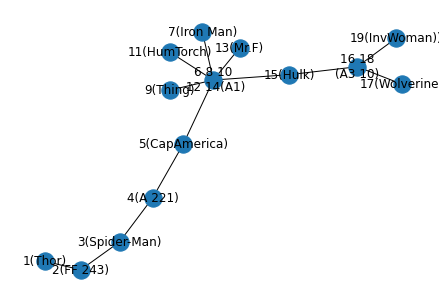

In [ ]:
functionality3(edges, h, h_1, h_n, top_N)

The path to follow to go from h_1 to h_n passing through some comics is shown above with numbered nodes (that also show the hero/comic name). Two comics **A 1** and **A3 10** are passed more than once.

##**Visualization 4**- Visualize the disconnected graph

In [ ]:
edges4 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/edges.csv', sep=',')
hero4 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/hero-network.csv', sep=',')
nodes4 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/nodes.csv', sep=',')

In [ ]:
hero1_hero2 = nx.from_pandas_edgelist(hero4, "hero1", "hero2")
hero_comic = nx.from_pandas_edgelist(edges4, "hero", "comic")
node_type = nx.from_pandas_edgelist(nodes4, "node", "type")

In [ ]:
giant_component = sorted(nx.connected_components(hero1_hero2), key=len, reverse=True)
giant_component = hero1_hero2.subgraph(giant_component[0])

In [ ]:
giant_component = nx.to_pandas_edgelist(giant_component)

In [ ]:
giant_component = giant_component.iloc[:30, :]
giant_component = nx.from_pandas_edgelist(giant_component, "source", "target")

In [ ]:
print('Possible start node:\n', giant_component.nodes())

Possible start node:
 ['LITTLE, ABNER', 'PRINCESS ZANDA', "BLACK PANTHER/T'CHAL", 'CARNIVORE/COUNT ANDR', 'IRON MAN/TONY STARK ', 'GOLDEN-BLADE', 'DIXON, GENERAL', 'IRON MAN IV/JAMES R.', 'JOCASTA', 'FUJIKAWA, RUMIKO', 'MADAME MENACE/SUNSET', 'JACOBS, GLENDA', 'WAR MACHINE II/PARNE', 'SAPPER', 'HOGAN, VIRGINIA PEPP', 'BINARY/CAROL DANVERS', 'FIN FANG FOOM/MIDGAR', 'MANN, DR. J. VERNON ', 'THOR/DR. DONALD BLAK', 'TEMPEST II/NICOLETTE', 'JARVIS, EDWIN ', 'INFERNO III/SAMANTHA', 'DECAY II/YOSHIRO HAC']


In [ ]:
hero_A = 'LITTLE, ABNER'
hero_B = 'PRINCESS ZANDA'

In [ ]:
from networkx.algorithms.connectivity import minimum_st_edge_cut

In [ ]:
minimum_cut_edge = dict(minimum_st_edge_cut(giant_component, s = hero_A, t = hero_B))
print(minimum_cut_edge)
minimum_cut = len(nx.minimum_edge_cut(giant_component, s = hero_A, t = hero_B))
print('\nThe minimum edge cut, for separating the original graph in two distinct subgraph is:', minimum_cut)

{'HOGAN, VIRGINIA PEPP': 'PRINCESS ZANDA', 'LITTLE, ABNER': 'PRINCESS ZANDA', 'IRON MAN/TONY STARK ': 'PRINCESS ZANDA', 'MANN, DR. J. VERNON ': 'PRINCESS ZANDA', "BLACK PANTHER/T'CHAL": 'PRINCESS ZANDA', 'CARNIVORE/COUNT ANDR': 'PRINCESS ZANDA', 'TEMPEST II/NICOLETTE': 'PRINCESS ZANDA', 'THOR/DR. DONALD BLAK': 'PRINCESS ZANDA', 'JARVIS, EDWIN ': 'PRINCESS ZANDA'}

The minimum edge cut, for separating the original graph in two distinct subgraph is: 9


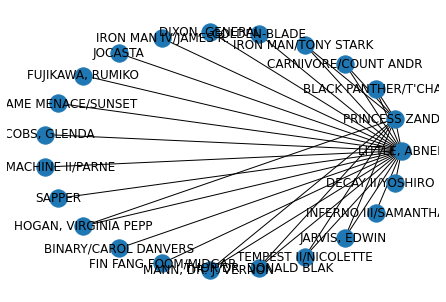

In [ ]:
nx.draw_circular(giant_component, labels = {node: node for node in giant_component.nodes()})

In [ ]:
minimum_cut_edge = [(k, v) for k, v in minimum_cut_edge.items()]
print(minimum_cut_edge)

[('HOGAN, VIRGINIA PEPP', 'PRINCESS ZANDA'), ('LITTLE, ABNER', 'PRINCESS ZANDA'), ('IRON MAN/TONY STARK ', 'PRINCESS ZANDA'), ('MANN, DR. J. VERNON ', 'PRINCESS ZANDA'), ("BLACK PANTHER/T'CHAL", 'PRINCESS ZANDA'), ('CARNIVORE/COUNT ANDR', 'PRINCESS ZANDA'), ('TEMPEST II/NICOLETTE', 'PRINCESS ZANDA'), ('THOR/DR. DONALD BLAK', 'PRINCESS ZANDA'), ('JARVIS, EDWIN ', 'PRINCESS ZANDA')]


In [ ]:
disconnected_hero = giant_component.copy()
disconnected_hero.remove_edges_from(minimum_cut_edge)

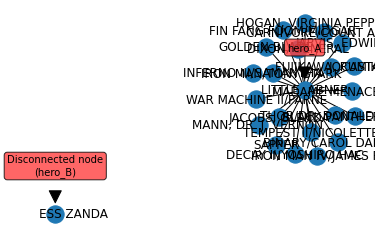

In [ ]:
plt.figure()
ax = plt.gca()

pos = nx.spring_layout(disconnected_hero)
nx.draw(disconnected_hero, pos, labels = {node: node for node in disconnected_hero.nodes()})

ax.annotate("Disconnected node\n(hero_B)", xy=pos.get(hero_B), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("hero_A", xy=pos.get(hero_A), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.show()

##**Visualization 5** - Visualize the communities


In [ ]:
edges5 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/edges.csv', sep=',')
hero5 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/hero-network.csv', sep=',')
nodes5 = pd.read_csv('/content/drive/MyDrive/ADM_HW5/nodes.csv', sep=',')

In [ ]:
hero1_hero2 = nx.from_pandas_edgelist(hero5, "hero1", "hero2")
hero_comic = nx.from_pandas_edgelist(edges5, "hero", "comic")
node_type = nx.from_pandas_edgelist(nodes5, "node", "type")

In [ ]:
from networkx.algorithms import community

In [ ]:
hero1_hero2 = nx.from_pandas_edgelist(hero5.iloc[:,:], "hero1", "hero2")

In [ ]:
communities = nx.community.girvan_newman(giant_component)
communities_frame = pd.DataFrame(communities)
communities_frame

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,"{WAR MACHINE II/PARNE, PRINCESS ZANDA, JACOBS,...",{GOLDEN-BLADE},None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"{WAR MACHINE II/PARNE, PRINCESS ZANDA, JACOBS,...",{GOLDEN-BLADE},"{DIXON, GENERAL}",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"{WAR MACHINE II/PARNE, PRINCESS ZANDA, JACOBS,...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"{WAR MACHINE II/PARNE, PRINCESS ZANDA, JACOBS,...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"{JARVIS, EDWIN , LITTLE, ABNER, WAR MACHINE II...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,"{JARVIS, EDWIN , LITTLE, ABNER, WAR MACHINE II...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,"{JARVIS, EDWIN , LITTLE, ABNER, WAR MACHINE II...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",None,None,...,None,None,None,None,None,None,None,None,None,None
7,"{JARVIS, EDWIN , LITTLE, ABNER, CARNIVORE/COUN...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},None,...,None,None,None,None,None,None,None,None,None,None
8,"{JARVIS, EDWIN , LITTLE, ABNER, CARNIVORE/COUN...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},{SAPPER},...,None,None,None,None,None,None,None,None,None,None
9,"{JARVIS, EDWIN , LITTLE, ABNER, CARNIVORE/COUN...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},{SAPPER},...,None,None,None,None,None,None,None,None,None,None


# **Algorithmic Question**

In [ ]:
def count_path(instr):
    counter=0
    n=len(instr)
    
    if instr[0]=='D':
        instr.pop(0)
        instr2=instr.copy()
        for i in range(0,2):
            for j in range(0,3):
                paths=[]
                for k in range(i+1,3):
                    paths.append([[i,j],[k,j]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1

    elif instr[0]=='U':
        instr.pop(0)
        instr2=instr.copy()
        for i in range(1,3):
            for j in range(0,3):
                paths=[]
                for k in range(i-1,-1,-1):
                    paths.append([[i,j],[k,j]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        print('R')
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
    elif instr[0]=='R':
        instr.pop(0)
        instr2=instr.copy()
        for i in range(0,3):
            for j in range(0,2):
                paths=[]
                for k in range(j+1,3):
                    paths.append([[i,j],[i,k]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
    elif instr[0]=='L':
        instr.pop(0)
        instr2=instr.copy()
        for i in range(0,2):
            for j in range(1,3):
                paths=[]
                for k in range(j-1,-1,-1):
                    paths.append([[i,j],[i,k]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
        
    return(counter)

In [ ]:
instr = input()
instructions = [*instr]
count_path(instructions)

DRU


15